In [2]:
!pip install pandas
!pip install torch
!pip install numpy
!pip install sklearn
!pip install tqdm
!pip install seaborn
!pip install matplotlib
!pip install tensorboard

  Using cached sklearn-0.0.post5.tar.gz (3.7 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached protobuf-4.23.3-cp310-abi3-win_amd64.whl (422 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.7.1-py3-none-any.whl (2.4 kB)
  Using cached Werkzeug-2.3.6-py3-none-any.whl (242 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached grpcio-1.56.0-cp310-cp310-win_amd64.whl (4.2 MB)
  Using cached google_auth-2.21.0-py2.py3-none-any.whl (182 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached cachetools-5.3.1-py3-none-any.whl (9.3 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.5.0-py2.py3-none-any.whl (83 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)


In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from functools import reduce
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Setup seed, device and tensorboard
torch.manual_seed(69)
device = "cuda" if torch.cuda.is_available() else "cpu"
writer = SummaryWriter('runs')

writer.add_custom_scalars({
    "stats": {
        "loss": ["Multiline", ["loss/train", "loss/validation"]],
        "accuracy": ["Multiline", ["accuracy/validation"]]
    }
})

In [5]:
def train_test_split(data):
    """
    Function for seperating test data from training data
    """
    x_train, x_test = pd.DataFrame(), pd.DataFrame()
    y = pd.DataFrame()

    for i in range(int(len(data.index) / 200)):
        df_number = data.iloc[i*200:i*200+200]
        x_train = pd.concat(
            [x_train, df_number.iloc[0:100]], ignore_index=True)
        x_test = pd.concat(
            [x_test, df_number.iloc[100:200]], ignore_index=True)
        y = pd.concat([y, pd.DataFrame(np.repeat(i, 100))], ignore_index=True)

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    y = y.to_numpy().flatten()

    return (x_train, y), (x_test, y)

In [13]:
class MyDataSet(Dataset):
    def __init__(self, x, y, normalize, classes=10):
        self.x, self.y = x, y
        self.x = torch.tensor(
            self.x / normalize).to(torch.float32).to(device)
        self.y = F.one_hot(torch.from_numpy(
            self.y).to(torch.int64), num_classes=classes).to(torch.float32).to(device)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [7]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.layers = nn.ModuleList([
            nn.Linear(size, 256, device=device),
            nn.ReLU(),
            nn.Linear(256, 128, device=device),
            nn.ReLU(),
            nn.Linear(128, 64, device=device),
            nn.ReLU(),
            nn.Linear(64, 10, device=device)
        ])

    def forward(self, x):
        x = x.view(-1, self.size)

        return reduce(lambda input, layer: layer(input), list(self.layers), x)

In [8]:
def validate_model(dl, model):
    """
    Function for validating a model
    """
    with torch.no_grad():
        model.eval()
        num_correct = 0
        num_samples = 0
        total_loss = 0
        L = nn.CrossEntropyLoss()
        for _, (eval_x, eval_y) in enumerate(dl):
            num_samples = num_samples + eval_y.shape[0]
            y_pred = model(eval_x)
            loss = L(y_pred, eval_y)
            total_loss = total_loss + loss.item() / len(dl)
            num_correct = num_correct + (np.argmax(y_pred.cpu().detach().numpy()) == np.argmax(
                eval_y.cpu().detach().numpy())).sum().item()

        model.train()
        return num_correct, num_samples, total_loss

In [9]:
def train_model(x_train, y_train, model, n_epochs=10, folds=5, lr=0.05, weight_decay=0.005):
    """
    Model train loop
    """
    # Setup
    opt = SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    L = nn.CrossEntropyLoss()
    scheduler = StepLR(opt, step_size=10, gamma=0.5)
    cv = KFold(n_splits=folds, random_state=1, shuffle=True)

    # Accuracy
    accuracy = 0

    for fold_i, (train_i, eval_i) in enumerate(cv.split(x_train)):

        # Create datasets and dataloaders
        train_ds = MyDataSet(
            x_train[train_i], y_train[train_i], normalize=6, classes=10)
        eval_ds = MyDataSet(
            x_train[eval_i], y_train[eval_i], normalize=6, classes=10)
        train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
        validation_dl = DataLoader(eval_ds, shuffle=True)

        loop = tqdm(range(n_epochs))
        for epoch in loop:
            epoch_train_loss = 0

            # Train
            N = len(train_dl)
            for _, (x, y) in enumerate(train_dl):
                opt.zero_grad()
                loss_value = L(model(x), y)
                loss_value.backward()
                opt.step()
                epoch_train_loss = epoch_train_loss + loss_value.item() * 1/N

            # Decay learning rate
            scheduler.step()

            # Validate fold
            correct, samples, epoch_val_loss = validate_model(
                validation_dl, model)

            # Progress
            loop.set_description(
                f"Fold {fold_i} Epoch [{epoch + 1}/{n_epochs}]")
            loop.set_postfix(loss=str(round(epoch_train_loss, 4)),
                             acc=str(round(correct / samples, 2)))

            # Logging to tensorboard
            writer.add_scalar("loss/train", epoch_train_loss,
                              fold_i * n_epochs + epoch)
            writer.add_scalar("loss/validation", epoch_val_loss,
                              fold_i * n_epochs + epoch)
            writer.add_scalar("accuracy/validation", correct/samples * 100,
                              fold_i * n_epochs + epoch)
            accuracy = correct/samples

    return model, accuracy

In [10]:
def hyperparameter_optimization(x_test, y_test, x_train, y_train, model, lr_space, nr_epochs, l2_space, folds_space):
    """
    Function for performing grid search in a pre defined hyperparameter search space
    """
    test_ds = MyDataSet(x_test, y_test, normalize=6, classes=10)
    test_dl = DataLoader(test_ds)

    best_lr = None
    best_epochs = None
    best_l2 = None
    best_folds = None
    best_accuracy = 0
    for i in lr_space:
        for j in nr_epochs:
            for k in l2_space:
                for l in folds_space:
                    train_model(
                        x_train, y_train, model, j, l, i, k)

                    num_correct, num_samples, _ = validate_model(
                        test_dl, model)

                    if num_correct/num_samples > best_accuracy:
                        best_lr = i
                        best_epochs = j
                        best_l2 = k
                        best_folds = l
                        best_accuracy = num_correct/num_samples

                    # Reset model
                    for layer in model.children():
                        if hasattr(layer, 'reset_parameters'):
                            layer.reset_parameters()

                    print("ACCURACY: {} LR: {} EPOCH: {} L2: {} FOLDS: {}".format(
                        num_correct/num_samples, i, j, k, l))

    return best_lr, best_epochs, best_l2, best_folds

In [20]:
def generate_confusion_matrix(model, x_test, y_test):
    model.eval()

    with torch.no_grad():

        test_ds = MyDataSet(x_test, y_test, normalize=6, classes=10)
        test_dl = DataLoader(test_ds)

        # X = eval, Y = pred
        matrix = np.zeros(shape=(10, 10))

        for batch_id, (eval_x, eval_y) in enumerate(test_dl):

            y_pred = model(eval_x)

            index_eval = np.argmax(eval_y.cpu().detach().numpy())
            index_pred = np.argmax(y_pred.cpu().detach().numpy())

            matrix[index_pred, index_eval] += 1

        ax = sns.heatmap(matrix, linewidth=0.5, annot=True, fmt=".1f")
        ax.set(xlabel='Actual Value', ylabel='Model Prediction')
        plt.show()

In [18]:
# Main for training a model
(x_train, y_train), (x_test, y_test) = train_test_split(
    pd.read_csv('mfeat-pix.txt', sep="  ", header=None, engine="python"))

model = MyNeuralNetwork(16*15)

trained_model, _ = train_model(x_train, y_train, model)

Fold 4 Epoch [10/10]: 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, acc=1.0, loss=0.0211]


In [21]:
# Test model accuracy on test data
test_ds = MyDataSet(x_test, y_test, normalize=6)
test_dl = DataLoader(test_ds)
num_correct, num_samples, loss = validate_model(test_dl,trained_model)
print("Correct Predictions: {}, Total Predictions: {}, Evaluation Loss: {}".format(num_correct, num_samples, loss))

Correct Predictions: 962, Total Predictions: 1000, Evaluation Loss: 0.1464064307031296


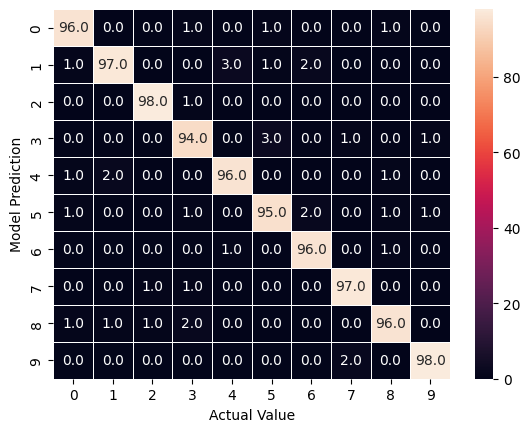

In [17]:
# Generate a confusion matrix with the trained model
generate_confusion_matrix(trained_model, x_test, y_test)

In [ ]:
# Grid search in the defined parameter space
best_lr, best_epochs, best_l2, best_folds = hyperparameter_optimization(x_test, y_test, x_train, y_train, model,
                                                                        [0.01,
                                                                            0.05],
                                                                        [10, 15, 30],
                                                                        [0.005, 0.02,
                                                                            0.04],
                                                                        [5]
                                                                        )

print("Best LR: {}, Best Epoch Count: {}, Best L2: {}, Best Fold Count: {}".format(best_lr, best_epochs, best_l2, best_folds))